# Tracking Bugs

So far, we have assumed that failures would be discovered and fixed by a single programmer during development. But what if the user who discovers a bug is different from the developer who eventually fixes it? In this case, users have to _report_ bugs, and one needs to ensure that reported bugs are systematically _tracked_. This is the job of dedicated _bug tracking systems_, which we will discuss (and demo) in this chapter.

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging.ipynb)

In [2]:
import bookutils

In [3]:
import Intro_Debugging

In [4]:
import os

In [5]:
# ignore
#
# WARNING: Unlike the other chapters in this book, 
# this chapter should NOT BE RUN AS A NOTEBOOK:
#
# * It will delete ALL data from an existing 
#   local _RedMine_ installation.
# * It will create new users and databases in an existing
#   local _MySQL_ installation.
# 
# The only reason to run this notebook is to create the book chapter,
# which is the task of Andreas Zeller.
# If you are not Andreas, you should exactly know what you are doing.

assert os.getenv('USER') == 'zeller'

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Tracking import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:



## Reporting Issues

So far, we have always assumed an environment in which software failures would be discovered by the very developers responsible for the code – that is, failures discovered (and fixed) during development. However, failures can also be discovered by third parties, such as

* _Testers_ whose job it is to test the code of developers
* Other _developers_ using the code
* _Users_ running the code as it is in production

In all these cases, developers need to be _informed_ about the fact that the program failed; if they won't know that a bug exists, it will be hard to fix it. This means that we have to set up mechanisms for _reporting bugs_ – manual ones and/or automated ones.

### What Goes in a Bug Report?

Let us start with the information a developer requires to _fix_ a bug. In a 2008 study \cite{Bettenburg2008}, Bettenburg et al. asked 872 developers from the Apache, Eclipse, and Mozilla projects to complete a survey on the most important information they need. From top to bottom, these were as follows:

#### Steps to Reproduce (83%)

This is a list of steps by which the failure would be reproduced. For instance:
> 1. I started the program using `$ python Debugger.py my_code.py`.
> 2. Then, at the `(debugger)` prompt, I entered `run` and pressed the <kbd>ENTER</kbd> key.

The easier it will be for the developer to reproduce the bug, the higher the chances it will be effectively fixed. [Reducing the steps to those relevant to reproduce the bug](DeltaDebugger.ipynb) can be helpful. But at the same time, the main problem experienced by developers as it comes to bug reports is _incomplete information_, and this especially applies to the steps to reproduce.

#### Stack Traces (57%)

These give hints on which parts of the code were active at the moment the failure occurred.
> I got this stack trace:

In [6]:
# ignore
from ExpectError import ExpectError

In [7]:
# ignore
def handle_command(s):
    scope = s.index(" in ")

In [8]:
with ExpectError():
    handle_command("run")

Traceback (most recent call last):
  File "<ipython-input-8-966505d12685>", line 2, in <module>
    handle_command("run")
  File "<ipython-input-7-7e98153317c3>", line 3, in handle_command
    scope = s.index(" in ")
ValueError: substring not found (expected)


Even though stack traces are useful, they are seldom reported by regular users, as they are difficult to obtain (or to find if included in log files). Automated crash reports (see below), however, frequently include them.

#### Test Cases (51%)

Test cases that reproduce the bug are also seen as important:
> I can reproduce the bug using the following code:
> `import Debugger; Debugger.handle_command("run")`

Non-developers hardly ever report test cases.

#### Observed Behavior (33%)

What the bug reporter observed as a failure.
> The program crashed with a `ValueError`.

In most cases, this mimics the steps to reproduce the bug.

#### Screenshots (26%)

Screenshots can further illustrate the failure.
> Here is a screenshot of the `Debugger` failing in Jupyter.

Screenshots are helpful for certain bugs only, such as GUI errors.

#### Expected Behavior (22%)

What the bug reporter expected instead.
> I expected the program not to crash.

#### Configuration Information (< 12%)

Perhaps surprisingly, the information that was seen as _least_ relevant for developers was:

* Version (12%)
* Build information (8%)
* Product (5%)
* Operating system (4%)
* Component (3%)
* Hardware (0%)

The relative low importance of these fields may be surprising as entering them is usually mandated in bug report forms. However, in \cite{Bettenburg2008}, developers stated that 
> [Operating System] fields are rarely needed as most [of] our bugs are usually found on all platforms.

This not meant to be read as these fields being totally irrelevant, as, of course, there can be bugs that occur only on specific platforms. Also, if a bug is reported for an older version, but is known to be fixed in a more current version, a simple resolution would be to ask the user to upgrade to the fixed version.

### Reporting Crashes Automatically

If a program crashes, it can be a good idea to have it automatically report the failure to developers. A common practice is to have a crashing program show a _bug report dialog_ allowing the user to report the crash to the vendor. The user is typically asked to provide additional details on how the failure came to be, and the crash report would be sent directly to the vendor's database:

![](https://upload.wikimedia.org/wikipedia/commons/b/b0/Screenshot-Bug_Buddy.png)

The automatic report typically includes a _stack trace_ and _configuration information_. These two do not reveal too many sensitive details about the user, yet already can help a lot in fixing a bug. In the interest of transparency, the user should be able to inspect all information sent to the vendor.

Besides stack traces and configuration information, such _crash reporters_ could, of course, collect much more - say the data the program operated on, logs, recorded steps to reproduce, or automatically recorded screenshots. However, all of these will likely include sensitive information; and despite their potential usefulness, it is typically better to not collect them in the first place.

## An Issue Tracker

At the developer's end, all issues reported need to be _tracked_ – that is, they have to be _registered_, they have to be _checked_, and of course, they have to be _addressed_. This process takes place via dedicated database systems, so-called _bug tracking systems_. 

The purposes of an issue tracking system include

* to collect and store all issue reports;
* to check the status of issues at all times; and
* to organize the debugging and development process.

Let us illustrate how these steps work, using the popular `Redmine` issue tracking system.

### Excursion: Setting up Redmine

To install Redmine, we followed the instructions at https://gist.github.com/johnjohndoe/2763243.
These final steps initialize the database:

In [9]:
import subprocess

In [10]:
import os
import sys

In [11]:
def with_ruby(cmd, inp='', timeout=10, show_stdout=False):
    print(f"$ {cmd}")
    shell = subprocess.Popen(['/bin/sh', '-c',
        f'''rvm_redmine=$HOME/.rvm/gems/ruby-2.7.2@redmine; \
rvm_global=$HOME/.rvm/gems/ruby-2.7.2@global; \
export GEM_PATH=$rvm_redmine:$rvm_global; \
export PATH=$rvm_redmine/bin:$rvm_global/bin:$HOME/.rvm/rubies/ruby-2.7.2/bin:$HOME/.rvm/bin:$PATH; \
cd $HOME/lib/redmine && {cmd}'''],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE,
                             universal_newlines=True)
    try:
        stdout_data, stderr_data = shell.communicate(inp, timeout=timeout)
    except subprocess.TimeoutExpired:
        shell.kill()
#         stdout_data, stderr_data = shell.communicate(inp)
#         if show_stdout:
#             print(stdout_data, end="")
#         print(stderr_data, file=sys.stderr, end="")
        raise

    print(stderr_data, file=sys.stderr, end="")
    if show_stdout:
        print(stdout_data, end="")

In [12]:
def with_mysql(cmd, timeout=2, show_stdout=False):
    print(f"sql>{cmd}")
    sql = subprocess.Popen(["mysql", "-u", "root",
                           "--default-character-set=utf8mb4"],
                            stdin=subprocess.PIPE,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE, 
                            universal_newlines=True)
    try:
        stdout_data, stderr_data = sql.communicate(cmd + ';', 
                                                   timeout=timeout)
    except suprocess.TimeoutExpired:
        sql.kill()
#         stdout_data, stderr_data = sql.communicate(inp)
#         if show_stdout:
#             print(stdout_data, end="")
#         print(stderr_data, file=sys.stderr, end="")
        raise

    print(stderr_data, file=sys.stderr, end="")
    if show_stdout:
        print(stdout_data, end="")

In [13]:
with_ruby("bundle config set without development test")

$ bundle config set without development test


In [14]:
with_ruby("bundle install")

$ bundle install


The dependency tzinfo-data (>= 0) will be unused by any of the platforms Bundler is installing for. Bundler is installing for ruby but the dependency is only for x86-mingw32, x64-mingw32, x86-mswin32. To add those platforms to the bundle, run `bundle lock --add-platform x86-mingw32 x64-mingw32 x86-mswin32`.
The dependency ffi (>= 0) will be unused by any of the platforms Bundler is installing for. Bundler is installing for ruby but the dependency is only for x86-mingw32, x64-mingw32, x86-mswin32. To add those platforms to the bundle, run `bundle lock --add-platform x86-mingw32 x64-mingw32 x86-mswin32`.


In [15]:
with_ruby("pkill sql; sleep 5")

$ pkill sql; sleep 5


In [16]:
try:
    with_ruby("mysql.server start", show_stdout=True)
except subprocess.TimeoutExpired:
    pass  # Can actually start without producing output

$ mysql.server start


In [17]:
with_mysql("drop database redmine")

sql>drop database redmine


In [18]:
with_mysql("drop user 'redmine'@'localhost'")

sql>drop user 'redmine'@'localhost'


In [19]:
with_mysql("create database redmine character set utf8")

sql>create database redmine character set utf8


In [20]:
with_mysql("create user 'redmine'@'localhost' identified by 'my_password'")

sql>create user 'redmine'@'localhost' identified by 'my_password'


In [21]:
with_mysql("grant all privileges on redmine.* to 'redmine'@'localhost'")

sql>grant all privileges on redmine.* to 'redmine'@'localhost'


In [22]:
with_ruby("bundle exec rake generate_secret_token")

$ bundle exec rake generate_secret_token


In [23]:
with_ruby("RAILS_ENV=production bundle exec rake db:migrate")

$ RAILS_ENV=production bundle exec rake db:migrate


In [24]:
with_ruby("RAILS_ENV=production bundle exec rake redmine:load_default_data", '\n')

$ RAILS_ENV=production bundle exec rake redmine:load_default_data


### End of Excursion

### Excursion: Starting Redmine

In [25]:
import os
import time

In [26]:
from multiprocessing import Process

In [27]:
def run_redmine(port):
    with_ruby(f'exec rails s -e production -p {port} > redmine.log 2>&1',
             timeout=3600)

In [28]:
def start_redmine(port=3000):
    process = Process(target=run_redmine, args=(port,))
    process.start()
    time.sleep(5)

    url = f"http://localhost:{port}"
    return process, url

In [29]:
redmine_process, redmine_url = start_redmine()

$ exec rails s -e production -p 3000 > redmine.log 2>&1


### End of Excursion

### Excursion: Remote Control with Selenium

We assume is that there is a set of *user interface elements* we can interact with.

[Selenium](https://www.seleniumhq.org) is a framework for testing Web applications by _automating interaction in the browser_.  Selenium provides an API that allows one to launch a Web browser, query the state of the user interface, and interact with individual user interface elements.  The Selenium API is available in a number of languages; we use the [Selenium API for Python](https://selenium-python.readthedocs.io/index.html).

A Selenium *web driver* is the interface between a program and a browser controlled by the program.

In [30]:
from selenium import webdriver

In [31]:
from selenium.webdriver.common.keys import Keys

The following code starts a Firefox browser in the background, which we then control through the web driver.

In [32]:
BROWSER = 'firefox'

In [33]:
with_ruby("pkill Firefox.app firefox-bin")

$ pkill Firefox.app firefox-bin


**Note:** If you don't have Firefox installed, you can also set `BROWSER` to `'chrome'` to use Google Chrome instead.

In [34]:
# BROWSER = 'chrome'

When running this outside of Jupyter notebooks, the browser is _headless_, meaning that it does not show on the screen.

In [35]:
from bookutils import rich_output

In [36]:
# HEADLESS = not rich_output()
HEADLESS = False

In [37]:
def start_webdriver(browser=BROWSER, headless=HEADLESS, zoom=1.4):
    if browser == 'firefox':
        options = webdriver.FirefoxOptions()
    if browser == 'chrome':
        options = webdriver.ChromeOptions()

    if headless and browser == 'chrome':
        options.add_argument('headless')
    else:
        options.headless = headless

    # Start the browser, and obtain a _web driver_ object such that we can interact with it.
    if browser == 'firefox':
        # For firefox, set a higher resolution for our screenshots
        profile = webdriver.firefox.firefox_profile.FirefoxProfile()
        profile.set_preference("layout.css.devPixelsPerPx", repr(zoom))
        redmine_gui = webdriver.Firefox(firefox_profile=profile, options=options)

        # We set the window size such that it fits
        redmine_gui.set_window_size(500, 600)  # was 1024, 600

    elif browser == 'chrome':
        redmine_gui = webdriver.Chrome(options=options)
        redmine_gui.set_window_size(1024, 510 if headless else 640)

    return redmine_gui

In [38]:
redmine_gui = start_webdriver(browser=BROWSER, headless=HEADLESS)

We can now interact with the browser programmatically.  First, we have it navigate to the URL of our Web server:

In [39]:
redmine_gui.get(redmine_url)

To see what the "headless" browser displays, we can obtain a screenshot.  We see that it actually displays the home page.

In [40]:
from IPython.display import display, Image

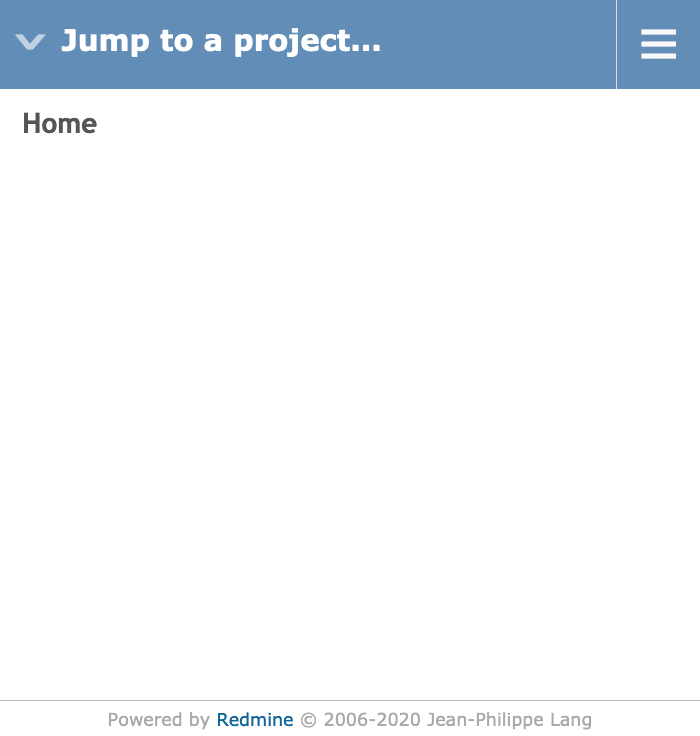

In [41]:
Image(redmine_gui.get_screenshot_as_png())

### End of Excursion

### Excursion: Screenshots with Drop Shadows

By default, our screenshots are flat. We add a drop shadow to make them look nicer.
With help from https://graphicdesign.stackexchange.com/questions/117272/how-to-add-drop-shadow-to-a-picture-via-cli

In [42]:
import tempfile

In [43]:
def drop_shadow(contents):
    with tempfile.NamedTemporaryFile() as tmp:
        tmp.write(contents)
        convert = subprocess.Popen(
            ['convert', tmp.name,
            '(', '+clone', '-background', 'black', '-shadow', '50x10+15+15', ')',
            '+swap', '-background', 'none', '-layers', 'merge', '+repage', '-'],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout_data, stderr_data = convert.communicate()
    
    if stderr_data:
        print(stderr_data.decode("utf-8"), file=sys.stderr, end="")
        
    return stdout_data

In [44]:
def resize(contents, size):
    with tempfile.NamedTemporaryFile() as tmp:
        tmp.write(contents)
        convert = subprocess.Popen(
            ['convert', tmp.name, '-resize', size, '-'],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout_data, stderr_data = convert.communicate()
    
    if stderr_data:
        print(stderr_data.decode("utf-8"), file=sys.stderr, end="")
        
    return stdout_data

In [45]:
def screenshot(driver):
    return Image(resize(drop_shadow(redmine_gui.get_screenshot_as_png()), "50%"))

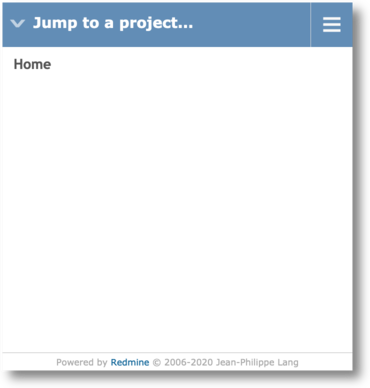

In [46]:
screenshot(redmine_gui)

### End of Excursion

### Excursion: First Registration at Redmine

In [47]:
redmine_gui.get(redmine_url + '/login')

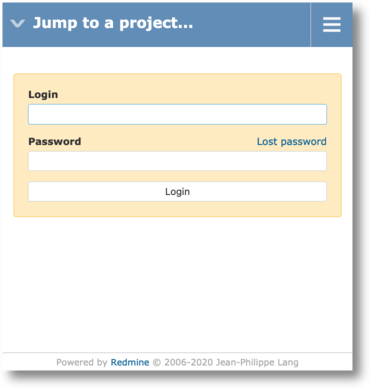

In [48]:
screenshot(redmine_gui)

In [49]:
redmine_gui.find_element_by_id("username").send_keys("admin")
redmine_gui.find_element_by_id("password").send_keys("admin")
redmine_gui.find_element_by_name("login").click()

In [50]:
time.sleep(2)

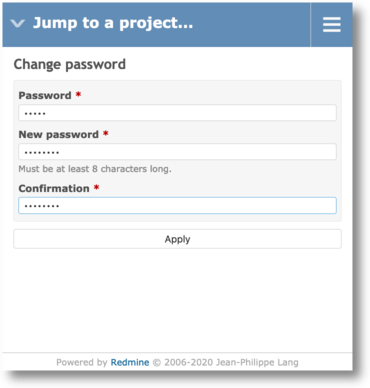

In [51]:
if redmine_gui.current_url.endswith('my/password'):
    redmine_gui.get(redmine_url + '/my/password')
    redmine_gui.find_element_by_id("password").send_keys("admin")
    redmine_gui.find_element_by_id("new_password").send_keys("admin001")
    redmine_gui.find_element_by_id("new_password_confirmation").send_keys("admin001")
    display(screenshot(redmine_gui))
    redmine_gui.find_element_by_name("commit").click()

In [52]:
redmine_gui.get(redmine_url + '/logout')
redmine_gui.find_element_by_name("commit").click()

### End of Excursion

This is what the _Redmine_ tracker starts with:

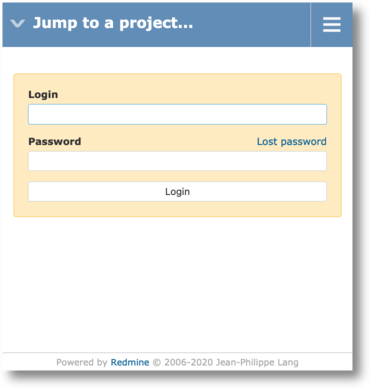

In [53]:
# ignore
redmine_gui.get(redmine_url + '/login')
screenshot(redmine_gui)

After we login, we see our account:

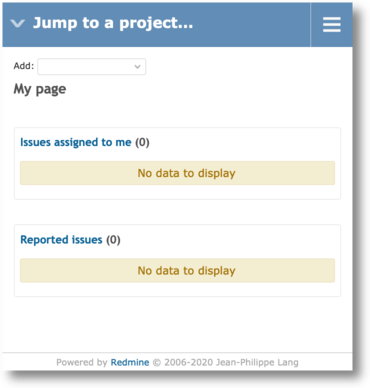

In [54]:
# ignore
redmine_gui.find_element_by_id("username").send_keys("admin")
redmine_gui.find_element_by_id("password").send_keys("admin001")
redmine_gui.find_element_by_name("login").click()
screenshot(redmine_gui)

### Excursion: Creating a Project

Let us check out the projects by clicking on "Projects".

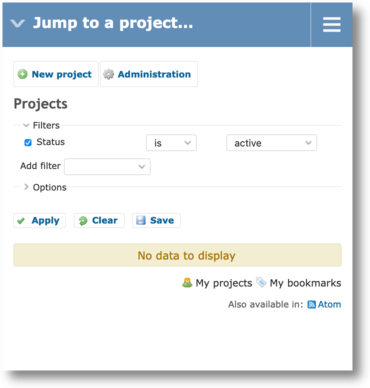

In [55]:
# ignore
redmine_gui.get(redmine_url + '/projects')
screenshot(redmine_gui)

We can now enter a project name and a description.

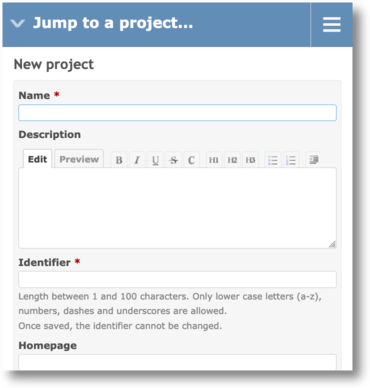

In [56]:
# ignore
redmine_gui.get(redmine_url + '/projects/new')
screenshot(redmine_gui)

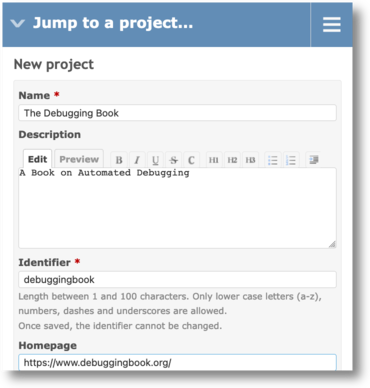

In [57]:
# ignore
redmine_gui.get(redmine_url + '/projects/new')
redmine_gui.find_element_by_id('project_name').send_keys("The Debugging Book")
redmine_gui.find_element_by_id('project_description').send_keys("A Book on Automated Debugging")
redmine_gui.find_element_by_id('project_identifier').clear()
redmine_gui.find_element_by_id('project_identifier').send_keys("debuggingbook")
redmine_gui.find_element_by_id('project_homepage').send_keys("https://www.debuggingbook.org/")
screenshot(redmine_gui)

In [58]:
# ignore
redmine_gui.find_element_by_name('commit').click()

### End of Excursion

We start with a list of projects.

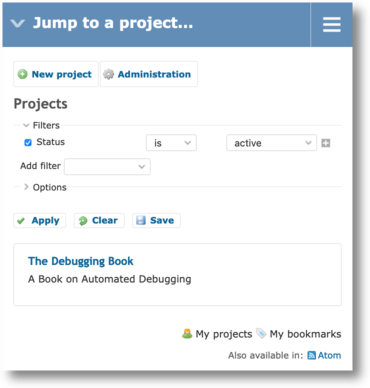

In [59]:
# ignore
redmine_gui.get(redmine_url + '/projects')
screenshot(redmine_gui)

Let us choose the (one) "debuggingbook" project.

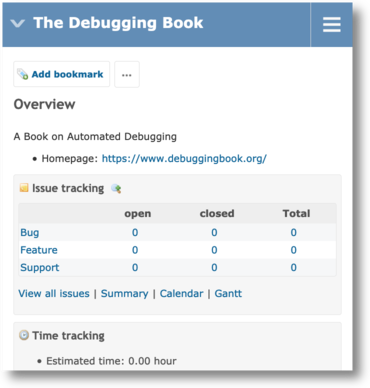

In [60]:
# ignore
redmine_gui.get(redmine_url + '/projects/debuggingbook')
screenshot(redmine_gui)

## Reporting an Issue

The most basic task of a bug tracker is to _report_ bugs. However, a bug tracker is a bit more general than just bugs – it can also track feature requests, support requests, and more. These are all summarized under the term "issue".

Let us take the role of a bug reporter – pardon, an _issue_ reporter – and report an issue. We can do this right from the _RedMine_ menu.

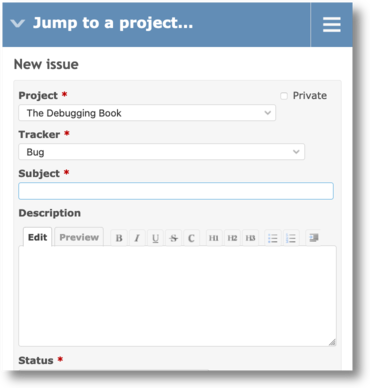

In [61]:
# ignore
redmine_gui.get(redmine_url + '/issues/new')
screenshot(redmine_gui)

Let's give our bug a name:

In [62]:
issue_title = "Does not render correctly on Nokia Communicator"

In [63]:
issue_description = \
"""The Debugging Book does not render correctly on the Nokia Communicator 9000.

Steps to reproduce:
1. On the Nokia, go to "https://debuggingbook.org/"
2. From the menu on top, select the chapter "Tracking Origins".
3. Scroll down to a place where a graph is supposed to be shown.
4. Instead of the graph, only a blank space is displayed.

How to fix:
* The graphs seem to come as SVG elements, but the Nokia Communicator does not support SVG rendering. Render them as JPEGs instead.
"""

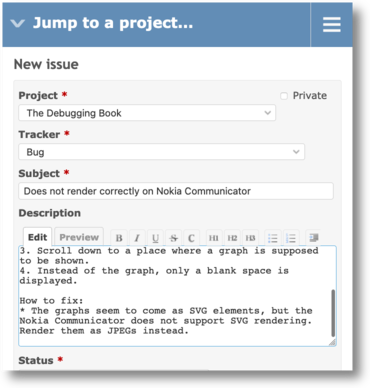

In [64]:
# ignore
redmine_gui.get(redmine_url + '/issues/new')

redmine_gui.find_element_by_id('issue_subject').send_keys(issue_title)
redmine_gui.find_element_by_id('issue_description').send_keys(issue_description)
screenshot(redmine_gui)

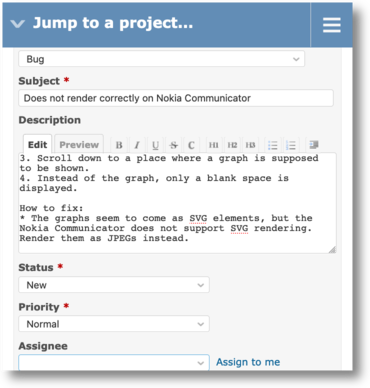

In [65]:
# ignore
redmine_gui.find_element_by_id('issue_assigned_to_id').click()
screenshot(redmine_gui)

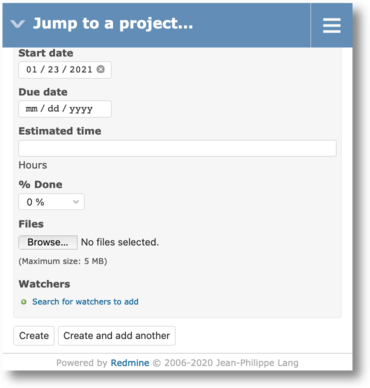

In [66]:
# ignore
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(redmine_gui)

Clicking on "Create" creates the new issue report.

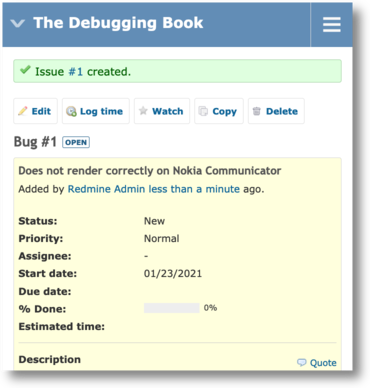

In [67]:
# ignore
redmine_gui.find_element_by_name('commit').click()
screenshot(redmine_gui)

We can enter a few more bug reports.

### Excursion: Adding Some More Issue Reports

In [68]:
def new_issue(issue_title, issue_description):
    redmine_gui.get(redmine_url + '/issues/new')

    redmine_gui.find_element_by_id('issue_subject').send_keys(issue_title)
    redmine_gui.find_element_by_id('issue_description').send_keys(issue_description)
    redmine_gui.find_element_by_name('commit').click()
    return screenshot(redmine_gui)

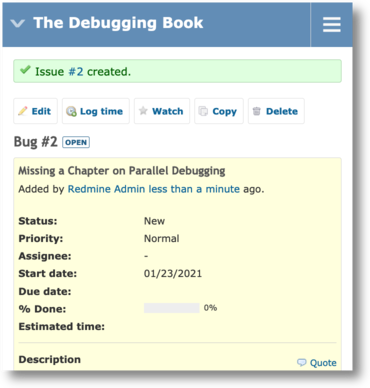

In [69]:
new_issue("Missing a Chapter on Parallel Debugging",
"""I am missing a chapter on (automatic) debugging of parallel and distributed systems,
including how to detect and repair data races, log message passing, and more.
In my experience, almost all programs are parallel today, so you are missing
an important subject.
""")

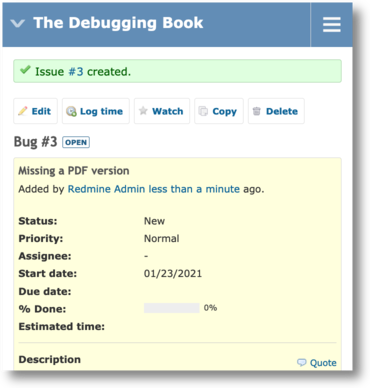

In [70]:
new_issue("Missing a PDF version",
"""Your 'book' does not provide a printed version. I think that printed books

* offer a more enjoyable experience for the reader
* allow me to annotate pages with my own remarks
* allow me to set dog-ear bookmatks
* allow me to show off what I'm currently reading (do you have a cover, too?)

Please provide a printed version - or, at least, produce a PDF version
of the debugging book, and make it available for download, such that I can print it myself.
""")

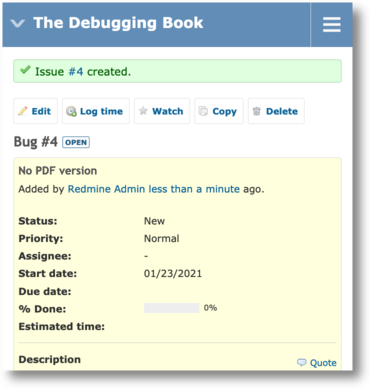

In [71]:
new_issue("No PDF version",
"""Can I have a printed version of your book? Please!""")

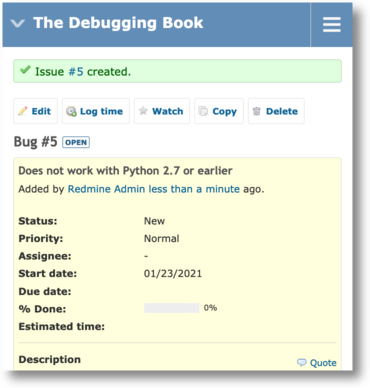

In [72]:
new_issue("Does not work with Python 2.7 or earlier",
"""I was deeply disappointed that your hew book requires Python 3.6 or later.
There are still several Python 2.x users out here (I, for one, cannot stand having to
type parentheses for every `print` statement), and I would love to run your code on
my Python 2.7 programs.

Would it be possible to backport the book's code such that it would run on Python 3.x
as well as Python 2.x? I would suggest that you add simple checks around your code
such as the following:

```
import sys

if sys.version_info.major >= 3:
    print("The result is", x)
else: 
    print "The result is", x
```

As an alternative, rewrite the book in Python 2 and have it automatically translate to
Python 3. This way, you could address all Python lovers, not just Python 3 ones.
""")

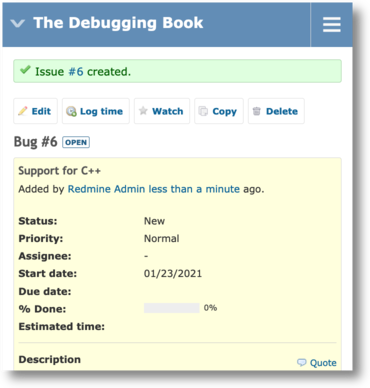

In [73]:
new_issue("Support for C++",
"""I had lots of fun with your 'debugging book'. Yet, I was somewhat disappointed
to see that all code examples are in and for Python programs only. Is there a chance
to get them to work on a real programming language such as C or C++? This would also
open the way to discuss several new debugging techniques for bugs that occur in these
languages only. A chapter on C++ move semantics, and how to fix them, for instance,
would be highly appreciated.
""")

### End of Excursion

## Managing Issues

Let us now switch sides and take the view of a _developer_ whose job it is to actually _handle_ all these issues. When our developers log in, the first thing they see is that there are a number of new issues that are all "open" – that is, in need to be addressed. (For a typical developer, this may well be the first task of the day.)

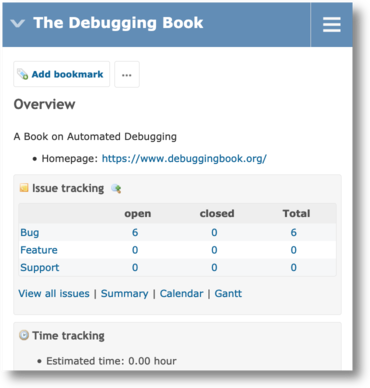

In [74]:
# ignore
redmine_gui.get(redmine_url + "/projects/debuggingbook")
screenshot(redmine_gui)

Clicking on "View all issues" shows us all issues reported so far.

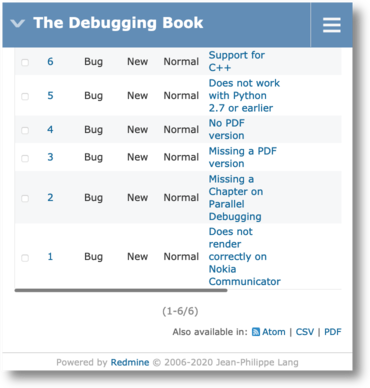

In [75]:
# ignore
redmine_gui.get(redmine_url + '/projects/debuggingbook/issues')
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(redmine_gui)

Let us do some bug _triaging_ here. Bug report #2 is not a bug – it is a feature request. We invoke its "actions" pop-up menu and mark it as "Feature".

In [76]:
# ignore
redmine_gui.get(redmine_url + "/issues/")

In [77]:
# ignore
redmine_gui.find_element_by_xpath("//tr[@id='issue-2']//a[@title='Actions']").click()
time.sleep(0.25)

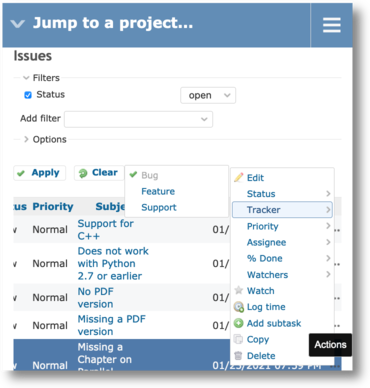

In [78]:
# ignore
tracker_item = redmine_gui.find_element_by_xpath(
    "//div[@id='context-menu']//a[text()='Tracker']")
actions = webdriver.ActionChains(redmine_gui)
actions.move_to_element(tracker_item)
actions.perform()
screenshot(redmine_gui)

In [79]:
# ignore
redmine_gui.find_element_by_xpath("//div[@id='context-menu']//a[text()='Feature']").click()

The same applies to bugs #3 and #4 (missing PDF) and #6 (no support for C++). We mark them as such as well.

In [80]:
# ignore
def mark_tracker(issue, tracker):
    redmine_gui.get(redmine_url + "/issues/")
    redmine_gui.find_element_by_xpath(
        f"//tr[@id='issue-{str(issue)}']//a[@title='Actions']").click()
    time.sleep(0.25)
    
    tracker_item = redmine_gui.find_element_by_xpath(
        "//div[@id='context-menu']//a[text()='Tracker']")
    actions = webdriver.ActionChains(redmine_gui)
    actions.move_to_element(tracker_item)
    actions.perform()
    time.sleep(0.25)
    
    redmine_gui.find_element_by_xpath(
        f"//div[@id='context-menu']//a[text()='{tracker}']").click()

In [81]:
# ignore
mark_tracker(3, "Feature")
mark_tracker(4, "Feature")
mark_tracker(6, "Feature")

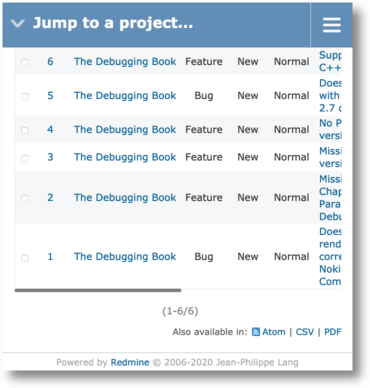

In [82]:
# ignore
redmine_gui.get(redmine_url + "/issues/")
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(redmine_gui)

The fact that we marked these issues as "feature requests" does not mean that they will not be worked on. However, we will give our first priority to the bugs listed.

## Assigning Priorities

After we have decided the priority for individual bugs, we can make this decision explicit by assigning a _priority_ to each bug. This allows our co-developers to see which things are the most pressing to work on.

Let us assume we have an important customer for whom fixing issue #1 is important. Through the context menu, we can assign issue #1 a priority of "Urgent". 

In [83]:
# ignore
redmine_gui.get(redmine_url + "/issues/")

In [84]:
# ignore
redmine_gui.find_element_by_xpath("//tr[@id='issue-1']//a[@title='Actions']").click()
time.sleep(0.25)

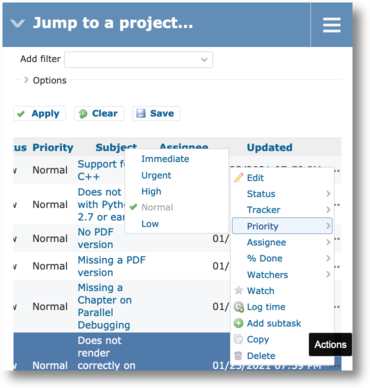

In [85]:
# ignore
priority_item = redmine_gui.find_element_by_xpath("//div[@id='context-menu']//a[text()='Priority']")
actions = webdriver.ActionChains(redmine_gui)
actions.move_to_element(priority_item)
actions.perform()
screenshot(redmine_gui)

In [86]:
# ignore
redmine_gui.find_element_by_xpath("//div[@id='context-menu']//a[text()='Urgent']").click()

We see that issue #1 is now listed as urgent.

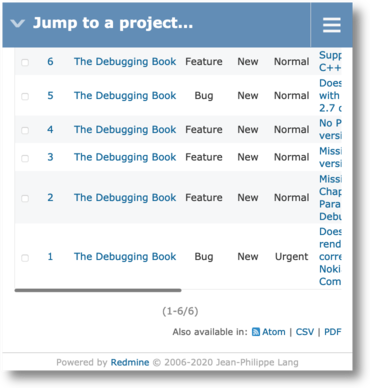

In [87]:
# ignore
redmine_gui.get(redmine_url + "/issues/")
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(redmine_gui)

## Assigning Issues

So far, all the listed bugs are "unassigned", which means that there is no developer who is currently working on them. Let us assign the "urgent" issue #1 to ourselves, such that we have something to do.

In [88]:
# ignore
redmine_gui.get(redmine_url + "/issues/")

In [89]:
# ignore
redmine_gui.find_element_by_xpath("//tr[@id='issue-1']//a[@title='Actions']").click()
time.sleep(0.25)

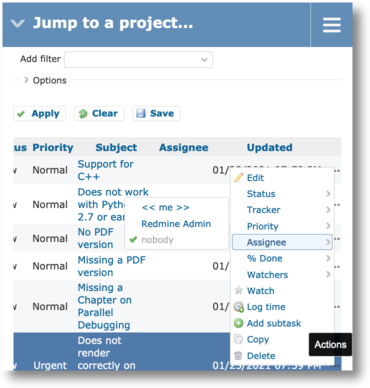

In [90]:
# ignore
assignee_item = redmine_gui.find_element_by_xpath(
    "//div[@id='context-menu']//a[text()='Assignee']")
actions = webdriver.ActionChains(redmine_gui)
actions.move_to_element(assignee_item)
actions.perform()
screenshot(redmine_gui)

By choosing the Actions menu, clicking on `Assignee`, and then `<< me >>`, we can assign the issue to ourselves.

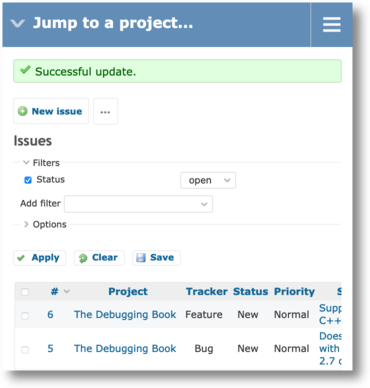

In [91]:
# ignore
redmine_gui.find_element_by_xpath("//div[@id='context-menu']//a[text()='<< me >>']").click()
screenshot(redmine_gui)

Of course, we could also go and assign the issue to other developers – depending on their competence and current workload. Very clearly, the ability to assign issues to individuals is a feature for managers.

## Resolving Issues

Let us switch perspectives again, and now take a _developer's role_ – that is, we now work on the issues assigned to us. We get these by clicking on "Issues assigned to me":

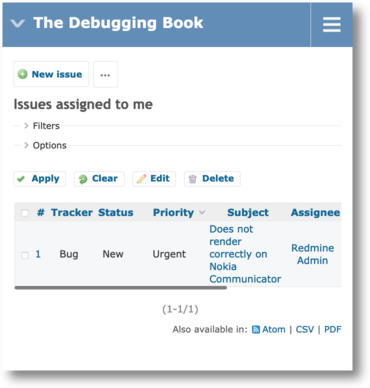

In [92]:
# ignore
redmine_gui.get(redmine_url + "/projects/debuggingbook/issues?query_id=1")
screenshot(redmine_gui)

By clicking on the issue number, we can see all details about the issue.

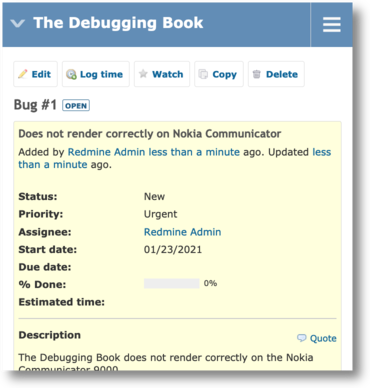

In [93]:
# ignore
redmine_gui.get(redmine_url + "/issues/1")
screenshot(redmine_gui)

We can inspect all features of the issue, including its history.

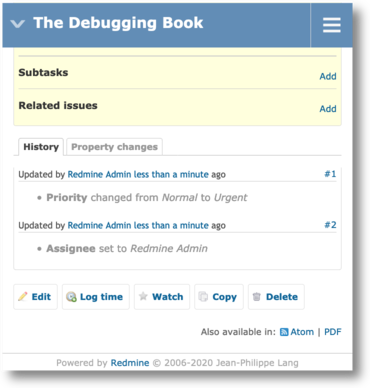

In [94]:
# ignore
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(redmine_gui)

Let us assume that we do have everything in hand we need to fix the bug. (Including a Nokia Communicator device for testing, that is.) This will take some time, during which we won't need our bug database.

![](https://upload.wikimedia.org/wikipedia/commons/2/2f/Prague_Astronomical_Clock_animated.gif)

Let us assume that we actually have fixed the bug! This means that we have to go back to our bug database such that we can mark the bug as _resolved_. For this, we open the issue again and click on "Edit", and then change the status from "New" to "Resolved".

In [95]:
# ignore
redmine_gui.get(redmine_url + "/issues/1/edit")
redmine_gui.find_element_by_id("issue_status_id").click()

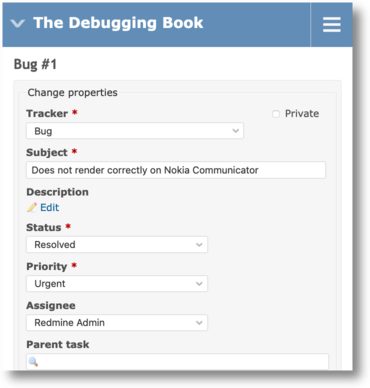

In [96]:
# ignore
redmine_gui.find_element_by_xpath("//option[text()='Resolved']").click()
screenshot(redmine_gui)

At the bottom, we can add more notes.

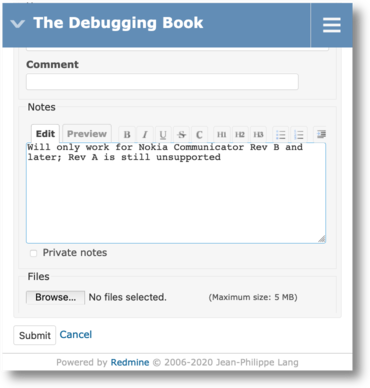

In [97]:
# ignore
redmine_gui.execute_script("window.scrollTo(0, document.body.scrollHeight);")
issue_notes = redmine_gui.find_element_by_id("issue_notes")
issue_notes.send_keys("Will only work for Nokia Communicator Rev B and later; "
    "Rev A is still unsupported")
screenshot(redmine_gui)

After clicking on "Submit", we are done. Time for the next bug to fix!

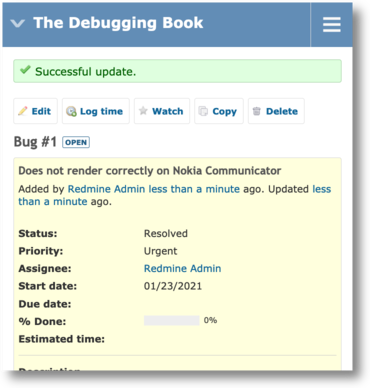

In [98]:
# ignore
redmine_gui.find_element_by_name("commit").click()
screenshot(redmine_gui)

## The Life Cycle of an Issue

We have successfully filed a bug. Now, this bug will enter the life cycle.

See also https://www.softwaretestinghelp.com/bug-life-cycle/

See https://gcc.gnu.org/bugzilla/page.cgi?id=fields.html for GCC Bugzilla

In [99]:
from Intro_Debugging import graph

In [100]:
from IPython.display import display

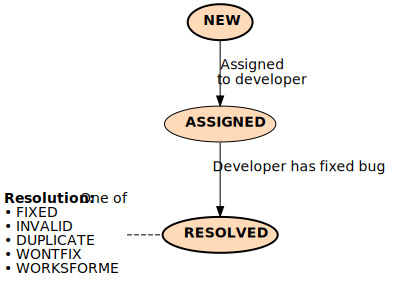

In [101]:
# ignore
life_cycle = graph()
life_cycle.attr(rankdir='TB')

life_cycle.node('New', label="<<b>NEW</b>>", penwidth='2.0')
life_cycle.node('Assigned', label="<<b>ASSIGNED</b>>")

with life_cycle.subgraph() as res:
    res.attr(rank='same')
    res.node('Resolved', label="<<b>RESOLVED</b>>", penwidth='2.0')
    res.node('Resolution',
                shape='plain',
                fillcolor='white',
                label="""<<b>Resolution:</b> One of<br align="left"/>
• FIXED<br align="left"/>
• INVALID<br align="left"/>
• DUPLICATE<br align="left"/>
• WONTFIX<br align="left"/>
• WORKSFORME<br align="left"/>
>""")
    res.node('Reopened', label="<<b>REOPENED</b>>", style='invis')

life_cycle.edge('New', 'Assigned', label=r"Assigned\lto developer")
life_cycle.edge('Assigned', 'Resolved', label="Developer has fixed bug")

life_cycle.edge('Resolution', 'Resolved', arrowhead='none', style='dashed')

life_cycle

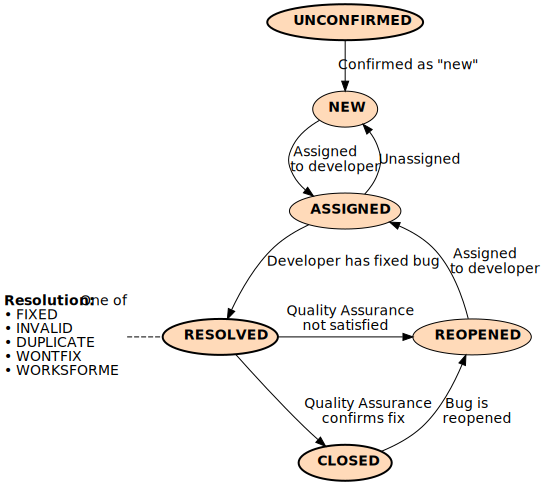

In [102]:
# ignore

life_cycle.node('Unconfirmed', label="<<b>UNCONFIRMED</b>>", penwidth='2.0')
# life_cycle.node('Verified', label="<<b>VERIFIED</b>>")
life_cycle.node('Closed', label="<<b>CLOSED</b>>", penwidth='2.0')
life_cycle.node('Reopened', label="<<b>REOPENED</b>>", style='filled')
life_cycle.node('New', label="<<b>NEW</b>>", penwidth='1.0')

life_cycle.edge('Unconfirmed', 'New', label="Confirmed as \"new\"")
life_cycle.edge('Assigned', 'New', label="Unassigned")
life_cycle.edge('Resolved', 'Closed', label=r"Quality Assurance\lconfirms fix")
life_cycle.edge('Resolved', 'Reopened', label=r"Quality Assurance\lnot satisfied")
life_cycle.edge('Reopened', 'Assigned', label=r"Assigned\lto developer")
# life_cycle.edge('Verified', 'Closed', label="Bug is closed")
life_cycle.edge('Closed', 'Reopened', label=r"Bug is\lreopened")

life_cycle

## Cleanup

In [103]:
import os

In [104]:
redmine_process.terminate()

In [105]:
redmine_gui.close()

In [106]:
os.system("pkill ruby")

0

## Synopsis

<!-- Automatically generated. Do not edit. -->



_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

```python
print(int_fuzzer())
```
```python
=> 76.5

```


## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [107]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [108]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_